In [2]:
!pip install fuzzywuzzy

In [35]:
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [172]:
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
books = pd.read_csv("C:/Users/kashi/Desktop/BX_Books.csv/BX_Books.csv", sep=';', encoding='latin-1',
                    low_memory=False, usecols = ['ISBN', 'Book-Title'])

r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv("C:/Users/kashi/Downloads/BX-Book-Ratings.csv/BX-Book-Ratings.csv", sep=';', encoding='latin-1',
                      low_memory=False)
print(ratings.head())
print(books.head())
ratings['id'] = ratings.groupby(['ISBN']).ngroup()
print(ratings.head())
books['id'] = books.groupby(['ISBN']).ngroup()
books.head()

   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6
         ISBN                                         Book-Title
0  0195153448                                Classical Mythology
1  0002005018                                       Clara Callan
2  0060973129                               Decision in Normandy
3  0374157065  Flu: The Story of the Great Influenza Pandemic...
4  0393045218                             The Mummies of Urumchi
   User-ID        ISBN  Book-Rating      id
0   276725  034545104X            0   57188
1   276726  0155061224            5   29750
2   276727  0446520802            0  107392
3   276729  052165615X            3  127253
4   276729  0521795028            6  127287


,ISBN,Book-Title,id
0,0195153448,Classical Mythology,25030
1,0002005018,Clara Callan,73
2,0060973129,Decision in Normandy,8212
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,60203
4,0393045218,The Mummies of Urumchi,71716


In [173]:
print(len(books.id.unique()))
ratings = pd.merge(ratings,books,on='ISBN', how='left')
ratings = ratings.drop(['id_x'], axis = 1)
ratings.head()

print(ratings[ratings['id_y'] == 46115.0].head())
books[books['id'] == 46115]
books = books.rename(columns={"Book-Title": "title"})

271379
       User-ID        ISBN  Book-Rating            Book-Title     id_y
0       276725  034545104X            0  Flesh Tones: A Novel  46115.0
15433     2313  034545104X            5  Flesh Tones: A Novel  46115.0
27533     6543  034545104X            0  Flesh Tones: A Novel  46115.0
36088     8680  034545104X            5  Flesh Tones: A Novel  46115.0
40794    10314  034545104X            9  Flesh Tones: A Novel  46115.0


In [174]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ISBN    271379 non-null  object
 1   title   271379 non-null  object
 2   id      271379 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.2+ MB


In [175]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   User-ID      1149780 non-null  int64  
 1   ISBN         1149780 non-null  object 
 2   Book-Rating  1149780 non-null  int64  
 3   Book-Title   1031175 non-null  object 
 4   id_y         1031175 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 52.6+ MB


In [176]:
# get count
ratings_cnt = pd.DataFrame(ratings.groupby('Book-Rating').size(), columns=['count'])
ratings_cnt

,count
Book-Rating,
0,716109
1,1770
2,2759
3,5996
4,8904
5,50974
6,36924
7,76457
8,103736


In [177]:
# add log count
ratings_cnt['log_count'] = np.log(ratings_cnt['count'])
ratings_cnt

,count,log_count
Book-Rating,,
0,716109,13.481588
1,1770,7.478735
2,2759,7.922624
3,5996,8.698848
4,8904,9.094256
5,50974,10.839071
6,36924,10.516617
7,76457,11.244484
8,103736,11.549604


Text(0, 0.5, 'number of ratings')

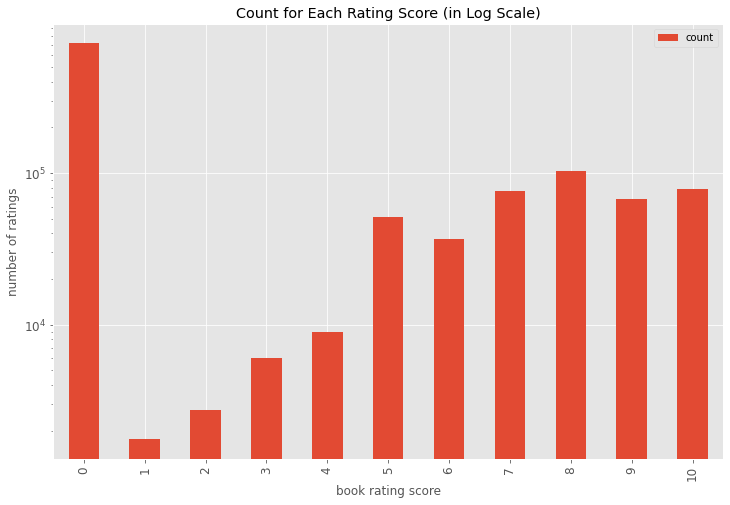

In [178]:
ax = ratings_cnt[['count']].reset_index().rename(columns={'index': 'Book-Rating'}).plot(
    x='Book-Rating',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("book rating score")
ax.set_ylabel("number of ratings")

In [179]:
# get rating frequency
books_cnt = pd.DataFrame(ratings.groupby('id_y').size(), columns=['count'])
books_cnt.head()

,count
id_y,
0.0,1
1.0,2
2.0,1
3.0,1
4.0,1


Text(0, 0.5, 'number of ratings')

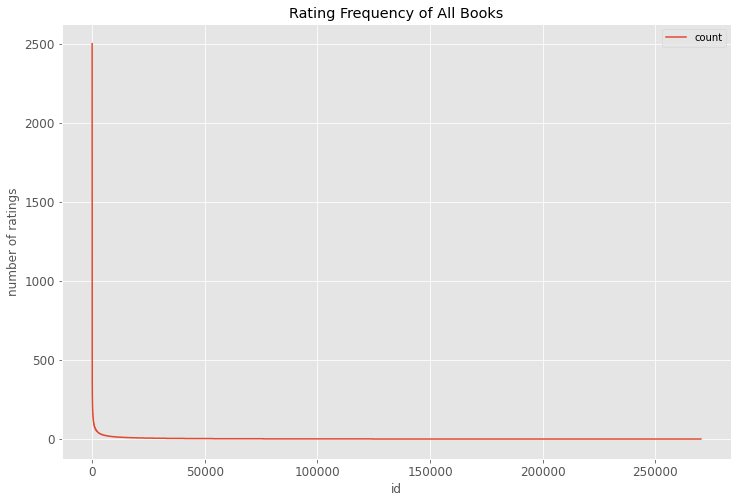

In [180]:
# plot rating frequency of all movies
ax = books_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Books',
        fontsize=12
    )
ax.set_xlabel("id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

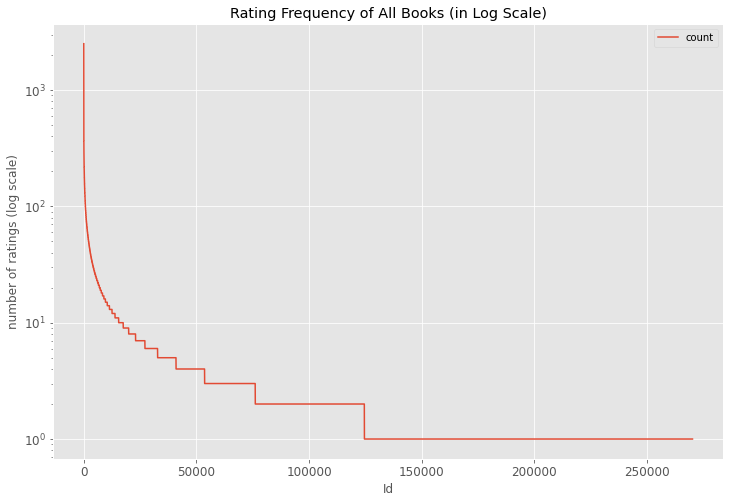

In [181]:
ax = books_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Books (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("Id")
ax.set_ylabel("number of ratings (log scale)")

In [182]:
books_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    2502.0
0.95      12.0
0.90       7.0
0.85       5.0
0.80       3.0
0.75       3.0
0.70       2.0
0.65       2.0
Name: count, dtype: float64

In [206]:
# filter data
popularity_thres = 10
popular_books = list(set(books_cnt.query('count >= @popularity_thres').index))
ratings_drop_books = ratings[ratings.id_y.isin(popular_books)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', ratings_drop_books.shape)

shape of original ratings data:  (1149780, 5)
shape of ratings data after dropping unpopular movies:  (520499, 5)


In [207]:
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_books.groupby('User-ID').size(), columns=['count'])
users_cnt.head()

,count
User-ID,
8,3
9,3
10,1
14,1
16,2


Text(0, 0.5, 'number of ratings')

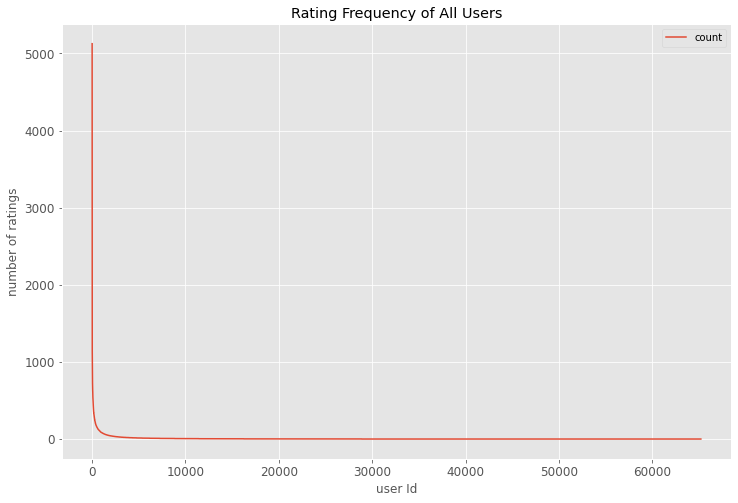

In [208]:
# plot rating frequency of all movies
ax = users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [209]:
users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    5126.0
0.95      24.0
0.90      11.0
0.85       7.0
0.80       5.0
0.75       3.0
0.70       3.0
0.65       2.0
0.60       2.0
0.55       1.0
Name: count, dtype: float64

In [236]:
# filter data
ratings_thres = 7
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_books[ratings_drop_books['User-ID'].isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular books and inactive users: ', ratings_drop_users.shape)

shape of original ratings data:  (1149780, 5)
shape of ratings data after dropping both unpopular books and inactive users:  (424513, 5)


In [237]:
# pivot and create movie-user matrix
book_user_mat = ratings_drop_users.pivot(index='id_y', columns='User-ID', values='Book-Rating').fillna(0)
# create mapper from movie title to index
book_to_idx = {
    book: i for i, book in 
    enumerate(list(books.set_index('id').loc[book_user_mat.index].title ))
}
# transform matrix to scipy sparse matrix
book_user_mat_sparse = csr_matrix(book_user_mat.values)
book_user_mat_sparse

<17475x9962 sparse matrix of type '<class 'numpy.float64'>'
	with 142223 stored elements in Compressed Sparse Row format>

In [245]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=40, n_jobs=-1)
# fit
model_knn.fit(book_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=40)

In [246]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]


def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [247]:
my_favorite = 'The Firm'

make_recommendation(
    model_knn=model_knn,
    data=book_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=book_to_idx,
    n_recommendations=1)

You have input movie: The Firm
Found possible matches in our database: ['The Firm', 'The Liar', 'The Heir', 'The Fermata', 'The First Time', 'The Offer', 'The Giver', 'The Choir', 'In the Frame', 'Into The Fire', 'The Mirror', 'The First Victim', 'The Informers', 'The Fire Rose', 'The DIETER', 'Home Fires', 'The Pigman', 'The First Law', 'The Ice Storm', 'The Winner', 'The Vig', 'The Body Farm', 'The Fresco', 'The Sinner', 'The Forest', 'The Fig Eater', 'The Med', 'The BFG', 'The Family', 'The Run', 'The Informant', 'The Flower Man', 'The White Room', 'After the Fire', 'The Sky Fisherman', 'The Pilgrimage', 'The Funnies', 'The Heiress', 'The Tin Man', 'The Painter', 'The Ignored', 'The Program', 'The Promise', 'The Visitor', 'Winter Fire', 'The Insider', 'The Sunbird', 'ETHAN FROME', 'The Game', 'The Face', 'Hellfire', 'The Rake', 'The Miko', 'The Ring', 'The Mask', 'The Jury', 'The Reef', 'The Maze', 'The List', 'Thin Air', 'The Gift', 'The Kiss', 'The Fifth Horseman', 'The Scar', 'Th